# Cross-modality Imputation with scGALA

This tutorial demonstrates how to use scGALA for cross-modality imputation, specifically generating RNA expression profiles from chromatin accessibility (ATAC-seq) data. This capability addresses a major challenge in single-cell multiomics analysis where many datasets contain measurements from only one modality when comprehensive characterization would ideally require multiple.

## Overview

scGALA's cross-modality imputation uses a Graph Attention Network (GAT) model within a graph-based cell alignment framework to predict RNA profiles for cells with only ATAC-seq measurements. The approach follows two key stages:

1. **Graph Data Generation**: Establishing cell-cell alignments between reference multimodal data (paired RNA/ATAC) and query ATAC data
2. **GAT-based Cross-modal Generation**: Using these alignments to guide RNA profile generation through a specialized GAT architecture

In this tutorial, we'll demonstrate this functionality using PBMC data. The preprocessed data is available in [Figshare](https://figshare.com/articles/dataset/Label_Transfer_Example_Data/28728617).

## Setting up the environment

First, let's import the necessary libraries. We'll use PyTorch Lightning to handle the training process, torch_geometric for working with graph data structures, and scGALA's DataProcessor and GATMapper classes for data preparation and model implementation.

In [ ]:
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
import torch
from scGALA.data import DataProcessor
from scGALA.model import GATMapper
import scanpy as sc
torch.set_float32_matmul_precision('high')

## Loading the data

We need two types of data for cross-modality imputation:

1. **Reference RNA data (`rna`)**: Contains gene expression profiles from cells with RNA-seq measurements
2. **Query ATAC data (`atac2rna`)**: Contains gene activity scores derived from ATAC-seq data, which we'll use to predict RNA expression

The gene activity scores are computed using peak counts in gene bodies and promoter regions, providing a representation compatible with RNA expression patterns. These have been preprocessed following the scGALA protocol including normalization, log-transformation, and selection of highly variable genes.

In [2]:
rna = sc.read_h5ad("./Data/pbmc/input_rna1.h5ad")
atac2rna = sc.read_h5ad("./Data/pbmc/input_atac2rna2.h5ad")
rna, atac2rna

(AnnData object with n_obs × n_vars = 5206 × 1286
     obs: 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations'
     var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank'
     obsm: 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 5206 × 1286
     obs: 'nCount_ATAC', 'nFeature_ATAC', 'seurat_annotations', 'nCount_ACTIVITY', 'nFeature_ACTIVITY'
     var: 'name'
     obsm: 'X_lsi', 'X_umap.atac'
     layers: 'counts')

## Data preparation and model setup

Now we'll prepare our data for the GAT-based cross-modal generation. This involves:

1. Initializing the DataProcessor with appropriate parameters
2. Loading our RNA and ATAC data, along with pre-computed anchors
3. Preparing the graph data structure for cross-modality imputation
4. Creating the GATMapper model with appropriate dimensions

The DataProcessor handles the construction of the graph $\mathcal{G}_{gen} = (\mathbf{X}_{gen}, \mathbf{A}_{gen})$, where:
- $\mathbf{X}_{gen}$ combines reference RNA expression and query gene activity scores
- $\mathbf{A}_{gen}$ represents connections within and between datasets

The `anchor_path` contains cell-cell alignments derived from scGALA's alignment process ($\hat{\mathbf{A}}_{ATAC}$), which are critical for guiding the information flow from reference to query cells.

In [ ]:
# Initialize data processor
processor = DataProcessor(n_neighbors=15)
processor.load_data(
    rna=rna,
    atac2rna=atac2rna,
    anchor_path='./anchors_mod_replace.csv'
)

# Prepare data
data = processor.prepare_data()

# Create model
model = GATMapper(
    in_channels=data.x.size(1),
    hidden_channels=256,
    out_channels=data.y.size(1)
)

### Understanding the model architecture

The `GATMapper` model implements a specialized Graph Attention Network (GAT) architecture optimized for translating chromatin accessibility patterns into gene expression profiles. It consists of multiple GAT layers that implement multi-head attention to encode both structural and feature-based information from each node's local neighborhood.

For cross-modality imputation, the model architecture can be expressed as:

$$\hat{\mathbf{X}}_{RNA}^{query} = ReLU(ELU(GAT_N(\mathbf{X}_N, \mathbf{A}_{gen}))), \text{where} \mathbf{X}_i = ELU(GAT_{i-1}(\mathbf{X}_{i-1}, \mathbf{A}_{gen}))$$

The model is trained to minimize a weighted mean squared error loss between predicted and actual RNA profiles, where the weights are determined by the quality of cell-cell alignments.

## Creating data loaders

We'll create data loaders for both training and validation. In this example, we're using the same data for both since we're working with a single graph that contains both reference and query cells.

In [4]:
# Create data loader
train_loader = DataLoader([data], batch_size=1)
val_loader = DataLoader([data], batch_size=1)

## Training the model

Now we'll train the GATMapper model using PyTorch Lightning. The training process employs:

1. The Adam optimizer with an initial learning rate of 1e-3 (default in the model)
2. A step-based learning rate scheduler that decays the learning rate periodically
3. Early stopping to prevent overfitting, with a patience of 10 epochs
4. Model checkpointing to save the best model based on validation loss

During training, information flows across the graph via the attention mechanism, allowing cells with only ATAC data to learn RNA expression patterns from similar cells in the reference dataset.

In [5]:
# Initialize trainer
trainer = pl.Trainer(
    max_epochs=-1,
    devices=[1],
    logger=pl.loggers.TensorBoardLogger('logs/'),
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10),
        pl.callbacks.ModelCheckpoint(monitor='val_loss')
    ]
)

# Train model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type    | Params
---------------------------------
0 | gat1 | GATConv | 1.3 M 
1 | gat2 | GATConv | 1.1 M 
2 | gat3 | GATConv | 1.3 M 
---------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.769    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5206. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 282: 100%|██████████| 1/1 [00:00<00:00, 19.55it/s, v_num=11, train_loss=0.118, val_loss=0.103]


## Generating and evaluating predicted RNA profiles

With our trained model, we can now predict RNA expression profiles for the query cells. We'll:

1. Generate predictions using the trained model
2. Create a new AnnData object with the predicted RNA expression
3. Run standard analysis steps (PCA, neighborhood graph, UMAP) on the predictions
4. Visualize the results by cell type

This allows us to assess how well the predicted RNA profiles capture the expected cell type structure.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.56it/s]


/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/md0/guo/miniforge3/envs/ggmnn_scanorama/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


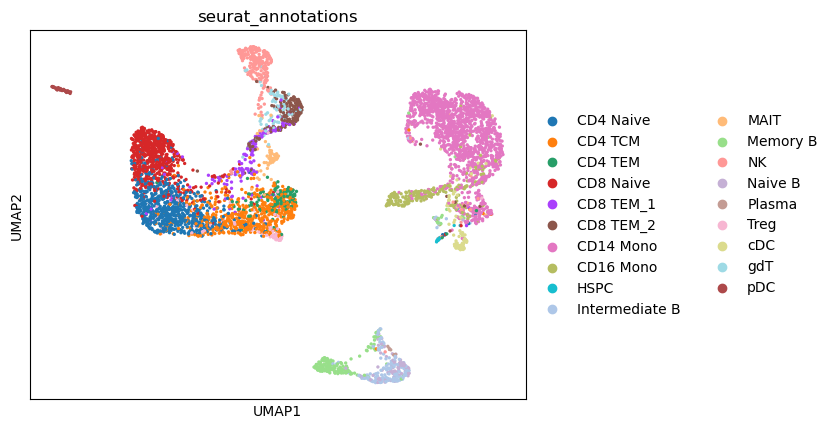

In [6]:
pred_rna2 = trainer.predict(model,val_loader)[0]
atac2rna2_pred = atac2rna.copy()
atac2rna2_pred.X = pred_rna2
sc.pp.pca(atac2rna2_pred)
sc.pp.neighbors(atac2rna2_pred)
sc.tl.umap(atac2rna2_pred)
sc.pl.umap(atac2rna2_pred,color='seurat_annotations')

## Saving the results

Finally, we'll save the predicted RNA expression profiles to an h5ad file for further analysis or integration with other datasets.

In [ ]:
sc.write('./pred_rna2.h5ad',atac2rna2_pred)

## Conclusion

In this tutorial, we've demonstrated how scGALA can be used for cross-modality imputation, specifically generating RNA expression profiles from chromatin accessibility data. This capability extends scGALA beyond an integration tool to a comprehensive multiomics analysis platform that can significantly expand the utility of existing single-modality datasets.

Key advantages of scGALA's cross-modality imputation approach include:

1. Leveraging graph-based cell alignments to guide RNA profile generation
2. Using attention mechanisms to prioritize the most relevant information from neighboring cells
3. Enabling comprehensive molecular characterization of cells without requiring additional experimental measurements

The predicted RNA profiles can be used for various downstream analyses, including differential expression, trajectory inference, and integration with other RNA datasets.